# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = layers.Conv2D(filters=filters, kernel_size=(5,5), strides=(1,1) ,
                      padding='same', activation='relu')(input_layer)
    output_layer = separable_conv2d_batchnorm(output_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled_layer = bilinear_upsample(small_ip_layer)
        
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    output_layer = layers.concatenate([upsampled_layer, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    x1 = encoder_block(inputs, 32, 2)
    x2 = encoder_block(x1, 64, 2)
    x3 = encoder_block(x2, 128, 2)
    x4 = encoder_block(x3, 256, 2)
    x5 = encoder_block(x4, 512, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    onebyone_conv_layer = conv2d_batchnorm(x5,1024,kernel_size=1,strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    x5_p = decoder_block(onebyone_conv_layer, x4, 512)
    x4_p = decoder_block(x5_p, x3, 256)
    x3_p = decoder_block(x4_p, x2, 128)
    x2_p = decoder_block(x3_p, x1, 64)
    x1_p = decoder_block(x2_p, inputs, 32)
    
    #======Network Shape========
    print(inputs)
    print(x1)
    print(x2)
    print(x3)
    print(x4)
    print(x5)
    print(onebyone_conv_layer)
    print(x5_p)
    print(x4_p)
    print(x3_p)
    print(x2_p)
    print(x1_p)
    #======Network Shape========
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x1_p)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 256
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

Tensor("input_1:0", shape=(?, 256, 256, 3), dtype=float32)
Tensor("batch_normalization/batchnorm/add_1:0", shape=(?, 128, 128, 32), dtype=float32)
Tensor("batch_normalization_2/batchnorm/add_1:0", shape=(?, 64, 64, 64), dtype=float32)
Tensor("batch_normalization_3/batchnorm/add_1:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("batch_normalization_4/batchnorm/add_1:0", shape=(?, 16, 16, 256), dtype=float32)
Tensor("batch_normalization_5/batchnorm/add_1:0", shape=(?, 8, 8, 512), dtype=float32)
Tensor("batch_normalization_6/batchnorm/add_1:0", shape=(?, 8, 8, 1024), dtype=float32)
Tensor("batch_normalization_8/batchnorm/add_1:0", shape=(?, 16, 16, 512), dtype=float32)
Tensor("batch_normalization_10/batchnorm/add_1:0", shape=(?, 32, 32, 256), dtype=float32)
Tensor("batch_normalization_12/batchnorm/add_1:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("batch_normalization_14/batchnorm/add_1:0", shape=(?, 128, 128, 64), dtype=float32)
Tensor("batch_normalization_16/batchnorm/add_1:0", s

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.0002
batch_size = 40
num_epochs = 100
num_img_train = 15211#6435
num_img_validation = 1184
steps_per_epoch = int(num_img_train / batch_size) +1
validation_steps = int(num_img_validation / batch_size) +1
workers = 4
print('Steps per epoch: ' + str(steps_per_epoch))
print('Validation steps: ' + str(validation_steps))

Steps per epoch: 381
Validation steps: 30


Epoch 1/100
380/381 [============================>.] - ETA: 1s - loss: 0.7363

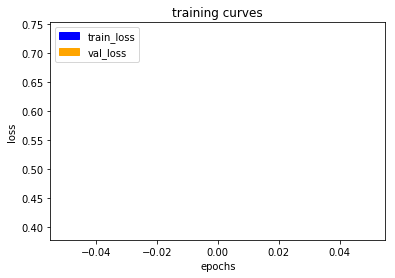

381/381 [==============================] - 748s - loss: 0.7354 - val_loss: 0.3952
Epoch 2/100
380/381 [============================>.] - ETA: 1s - loss: 0.2370

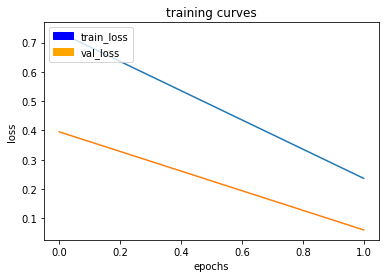

381/381 [==============================] - 745s - loss: 0.2367 - val_loss: 0.0602
Epoch 3/100
380/381 [============================>.] - ETA: 1s - loss: 0.0920

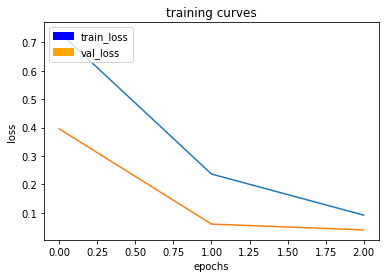

381/381 [==============================] - 748s - loss: 0.0919 - val_loss: 0.0397
Epoch 4/100
380/381 [============================>.] - ETA: 1s - loss: 0.0664

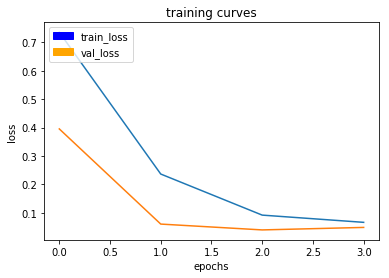

381/381 [==============================] - 747s - loss: 0.0664 - val_loss: 0.0485
Epoch 5/100
380/381 [============================>.] - ETA: 1s - loss: 0.0430

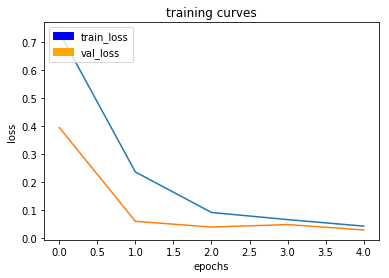

381/381 [==============================] - 747s - loss: 0.0430 - val_loss: 0.0295
Epoch 6/100
380/381 [============================>.] - ETA: 1s - loss: 0.0324

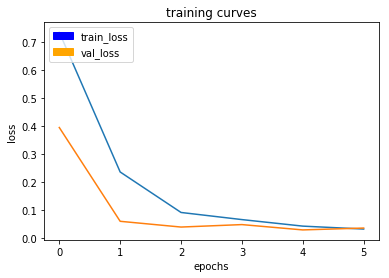

381/381 [==============================] - 749s - loss: 0.0325 - val_loss: 0.0362
Epoch 7/100
380/381 [============================>.] - ETA: 1s - loss: 0.0265

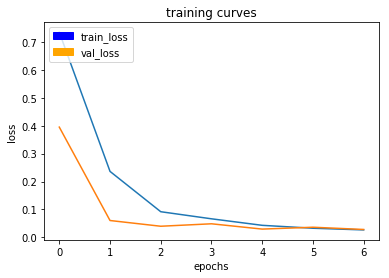

381/381 [==============================] - 748s - loss: 0.0265 - val_loss: 0.0281
Epoch 8/100
380/381 [============================>.] - ETA: 1s - loss: 0.0235

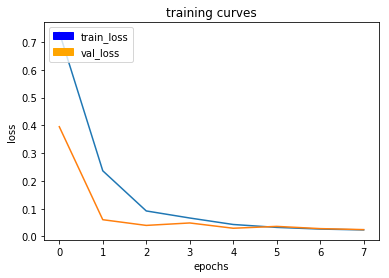

381/381 [==============================] - 748s - loss: 0.0235 - val_loss: 0.0245
Epoch 9/100
380/381 [============================>.] - ETA: 1s - loss: 0.0225

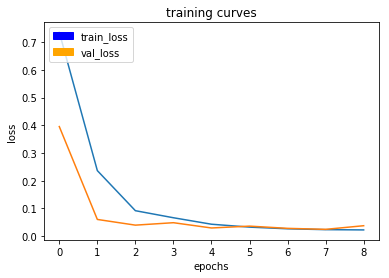

381/381 [==============================] - 748s - loss: 0.0225 - val_loss: 0.0376
Epoch 10/100
380/381 [============================>.] - ETA: 1s - loss: 0.0205

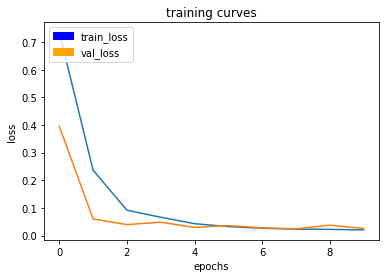

381/381 [==============================] - 748s - loss: 0.0205 - val_loss: 0.0256
Epoch 11/100
380/381 [============================>.] - ETA: 1s - loss: 0.0176

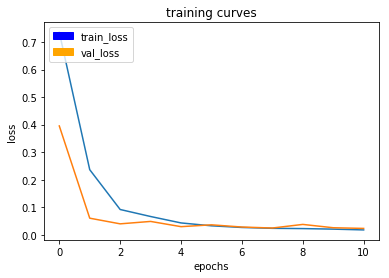

381/381 [==============================] - 749s - loss: 0.0176 - val_loss: 0.0231
Epoch 12/100
380/381 [============================>.] - ETA: 1s - loss: 0.0181

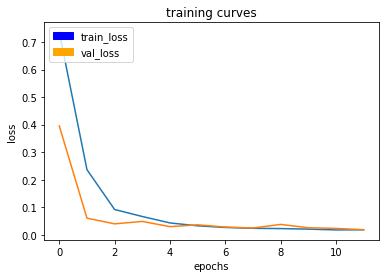

381/381 [==============================] - 748s - loss: 0.0181 - val_loss: 0.0184
Epoch 13/100
380/381 [============================>.] - ETA: 1s - loss: 0.0162

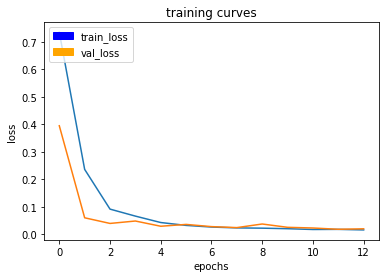

381/381 [==============================] - 749s - loss: 0.0161 - val_loss: 0.0202
Epoch 14/100
380/381 [============================>.] - ETA: 1s - loss: 0.0146

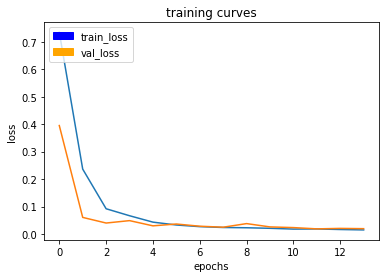

381/381 [==============================] - 748s - loss: 0.0146 - val_loss: 0.0192
Epoch 15/100
380/381 [============================>.] - ETA: 1s - loss: 0.0139

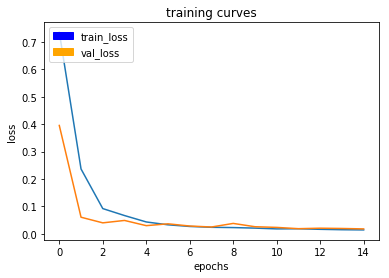

381/381 [==============================] - 747s - loss: 0.0139 - val_loss: 0.0176
Epoch 16/100
380/381 [============================>.] - ETA: 1s - loss: 0.0133

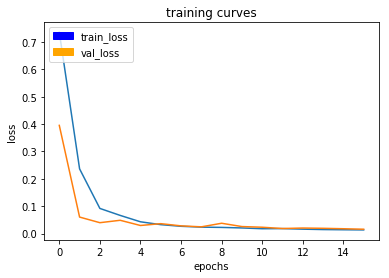

381/381 [==============================] - 747s - loss: 0.0133 - val_loss: 0.0159
Epoch 17/100
380/381 [============================>.] - ETA: 1s - loss: 0.0158

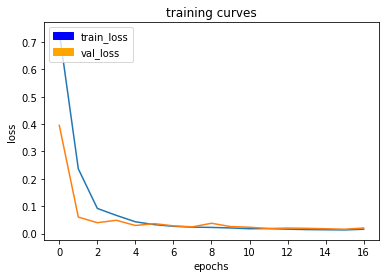

381/381 [==============================] - 747s - loss: 0.0158 - val_loss: 0.0204
Epoch 18/100
380/381 [============================>.] - ETA: 1s - loss: 0.0144

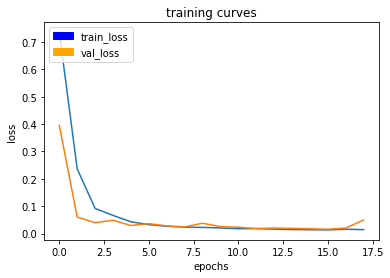

381/381 [==============================] - 747s - loss: 0.0144 - val_loss: 0.0493
Epoch 19/100
380/381 [============================>.] - ETA: 1s - loss: 0.0132

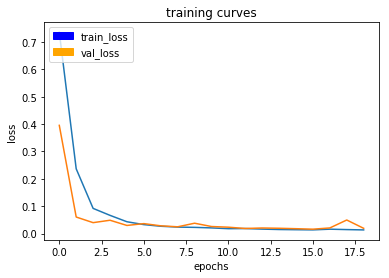

381/381 [==============================] - 747s - loss: 0.0132 - val_loss: 0.0190
Epoch 20/100
380/381 [============================>.] - ETA: 1s - loss: 0.0123

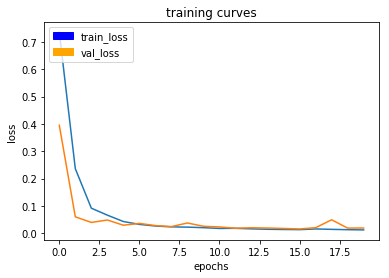

381/381 [==============================] - 747s - loss: 0.0123 - val_loss: 0.0191
Epoch 21/100
380/381 [============================>.] - ETA: 1s - loss: 0.0117

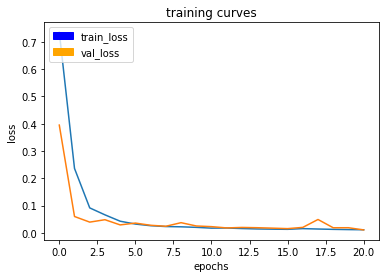

381/381 [==============================] - 748s - loss: 0.0117 - val_loss: 0.0111
Epoch 22/100
380/381 [============================>.] - ETA: 1s - loss: 0.0110

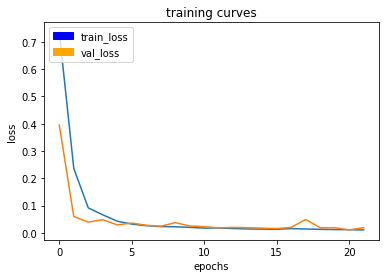

381/381 [==============================] - 748s - loss: 0.0110 - val_loss: 0.0193
Epoch 23/100
380/381 [============================>.] - ETA: 1s - loss: 0.0107

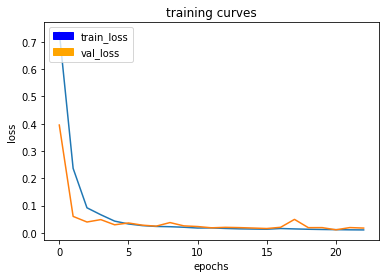

381/381 [==============================] - 748s - loss: 0.0107 - val_loss: 0.0175
Epoch 24/100
380/381 [============================>.] - ETA: 1s - loss: 0.0106

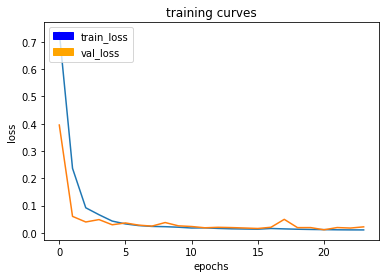

381/381 [==============================] - 748s - loss: 0.0106 - val_loss: 0.0218
Epoch 25/100
380/381 [============================>.] - ETA: 1s - loss: 0.0101

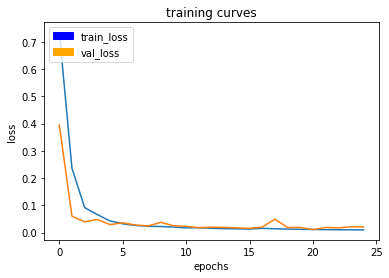

381/381 [==============================] - 748s - loss: 0.0101 - val_loss: 0.0208
Epoch 26/100
380/381 [============================>.] - ETA: 1s - loss: 0.0098

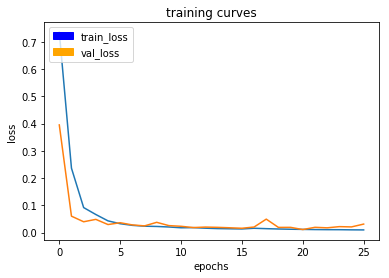

381/381 [==============================] - 748s - loss: 0.0098 - val_loss: 0.0312
Epoch 27/100
380/381 [============================>.] - ETA: 1s - loss: 0.0094

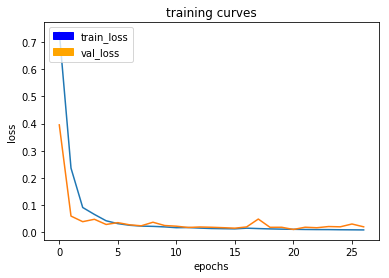

381/381 [==============================] - 747s - loss: 0.0094 - val_loss: 0.0208
Epoch 28/100
380/381 [============================>.] - ETA: 1s - loss: 0.0092

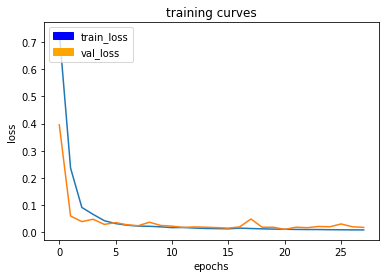

381/381 [==============================] - 748s - loss: 0.0092 - val_loss: 0.0185
Epoch 29/100
380/381 [============================>.] - ETA: 1s - loss: 0.0090

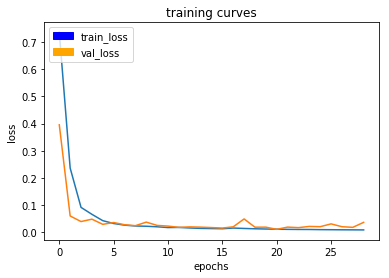

381/381 [==============================] - 748s - loss: 0.0090 - val_loss: 0.0368
Epoch 30/100
380/381 [============================>.] - ETA: 1s - loss: 0.0140

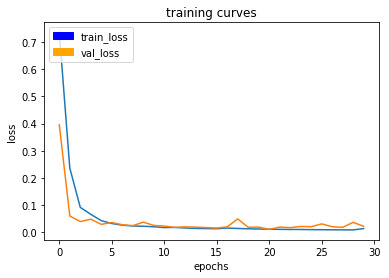

381/381 [==============================] - 748s - loss: 0.0140 - val_loss: 0.0222
Epoch 31/100
380/381 [============================>.] - ETA: 1s - loss: 0.0106

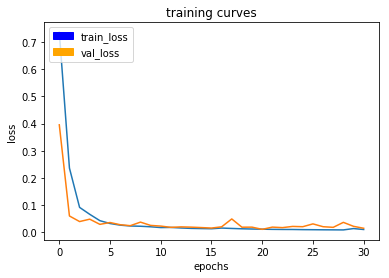

381/381 [==============================] - 749s - loss: 0.0105 - val_loss: 0.0151
Epoch 32/100
380/381 [============================>.] - ETA: 1s - loss: 0.0098

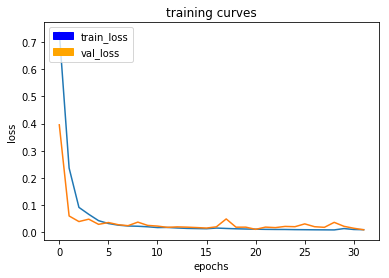

381/381 [==============================] - 747s - loss: 0.0098 - val_loss: 0.0095
Epoch 33/100
380/381 [============================>.] - ETA: 1s - loss: 0.0089

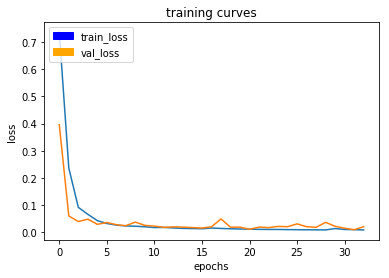

381/381 [==============================] - 749s - loss: 0.0090 - val_loss: 0.0208
Epoch 34/100
380/381 [============================>.] - ETA: 1s - loss: 0.0087

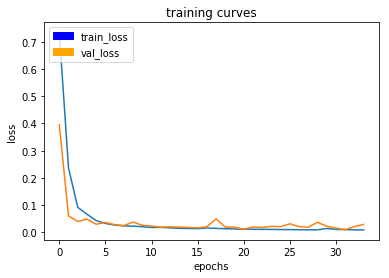

381/381 [==============================] - 749s - loss: 0.0087 - val_loss: 0.0291
Epoch 35/100
380/381 [============================>.] - ETA: 1s - loss: 0.0084

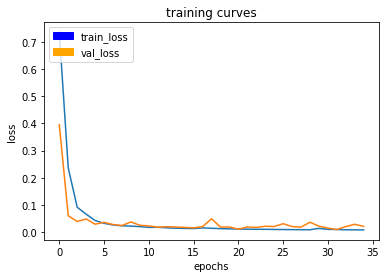

381/381 [==============================] - 748s - loss: 0.0084 - val_loss: 0.0214
Epoch 36/100
380/381 [============================>.] - ETA: 1s - loss: 0.0082

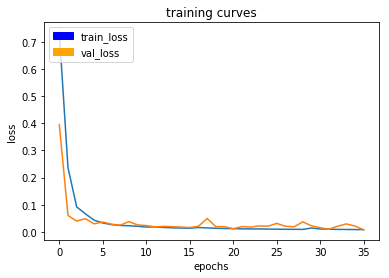

381/381 [==============================] - 748s - loss: 0.0082 - val_loss: 0.0070
Epoch 37/100
380/381 [============================>.] - ETA: 1s - loss: 0.0080

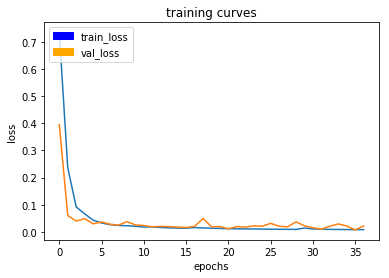

381/381 [==============================] - 748s - loss: 0.0080 - val_loss: 0.0214
Epoch 38/100
380/381 [============================>.] - ETA: 1s - loss: 0.0078

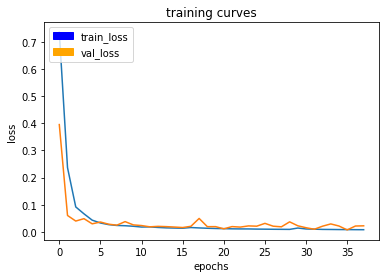

381/381 [==============================] - 748s - loss: 0.0078 - val_loss: 0.0221
Epoch 39/100
380/381 [============================>.] - ETA: 1s - loss: 0.0114

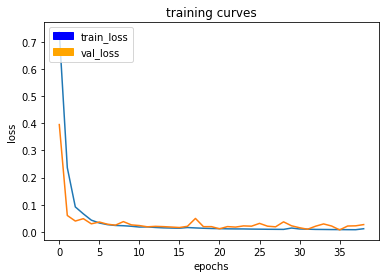

381/381 [==============================] - 748s - loss: 0.0114 - val_loss: 0.0267
Epoch 40/100
380/381 [============================>.] - ETA: 1s - loss: 0.0091

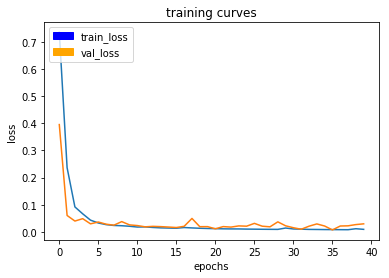

381/381 [==============================] - 747s - loss: 0.0091 - val_loss: 0.0295
Epoch 41/100
380/381 [============================>.] - ETA: 1s - loss: 0.0082

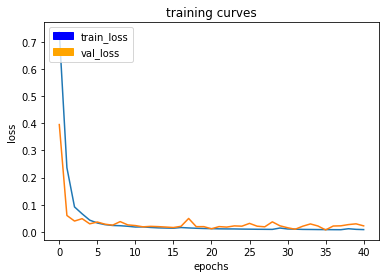

381/381 [==============================] - 748s - loss: 0.0082 - val_loss: 0.0220
Epoch 42/100
380/381 [============================>.] - ETA: 1s - loss: 0.0078

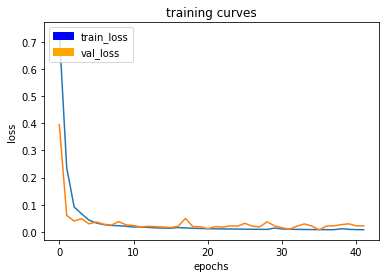

381/381 [==============================] - 748s - loss: 0.0078 - val_loss: 0.0220
Epoch 43/100
380/381 [============================>.] - ETA: 1s - loss: 0.0075

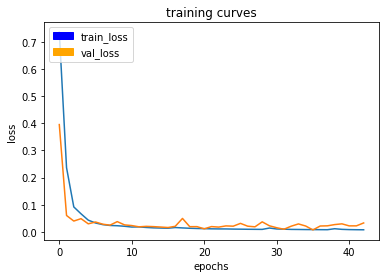

381/381 [==============================] - 747s - loss: 0.0075 - val_loss: 0.0327
Epoch 44/100
380/381 [============================>.] - ETA: 1s - loss: 0.0075

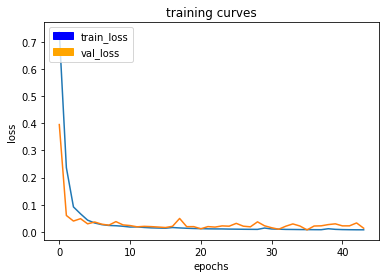

381/381 [==============================] - 748s - loss: 0.0075 - val_loss: 0.0133
Epoch 45/100
380/381 [============================>.] - ETA: 1s - loss: 0.0073

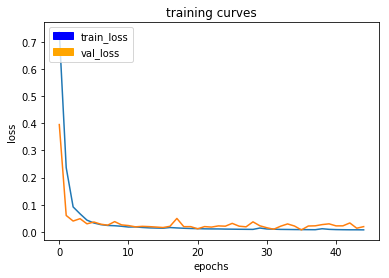

381/381 [==============================] - 748s - loss: 0.0073 - val_loss: 0.0191
Epoch 46/100
380/381 [============================>.] - ETA: 1s - loss: 0.0071

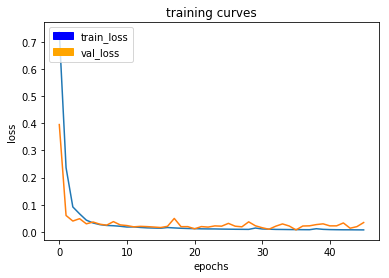

381/381 [==============================] - 747s - loss: 0.0071 - val_loss: 0.0342
Epoch 47/100
380/381 [============================>.] - ETA: 1s - loss: 0.0071

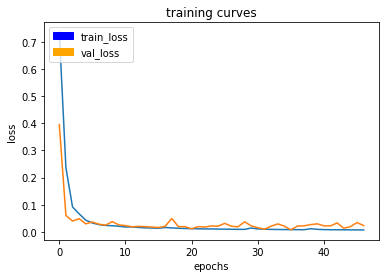

381/381 [==============================] - 747s - loss: 0.0071 - val_loss: 0.0229
Epoch 48/100
380/381 [============================>.] - ETA: 1s - loss: 0.0069

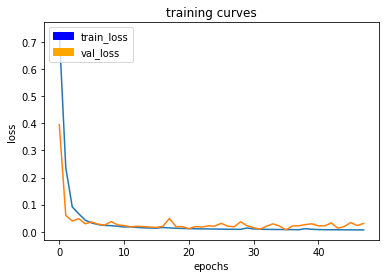

381/381 [==============================] - 748s - loss: 0.0069 - val_loss: 0.0307
Epoch 49/100
380/381 [============================>.] - ETA: 1s - loss: 0.0069

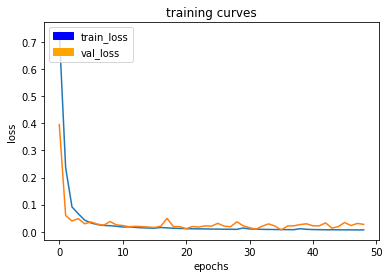

381/381 [==============================] - 747s - loss: 0.0069 - val_loss: 0.0273
Epoch 50/100
380/381 [============================>.] - ETA: 1s - loss: 0.0067

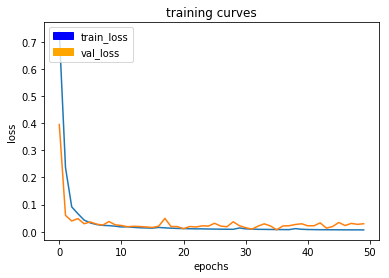

381/381 [==============================] - 746s - loss: 0.0067 - val_loss: 0.0295
Epoch 51/100
380/381 [============================>.] - ETA: 1s - loss: 0.0067

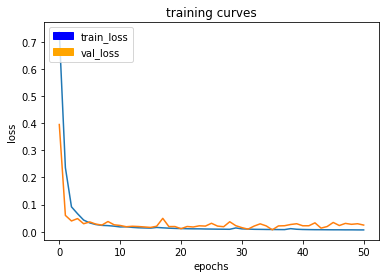

381/381 [==============================] - 748s - loss: 0.0067 - val_loss: 0.0245
Epoch 52/100
380/381 [============================>.] - ETA: 1s - loss: 0.0067

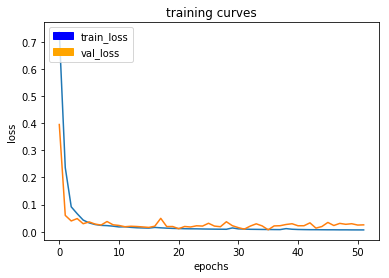

381/381 [==============================] - 749s - loss: 0.0067 - val_loss: 0.0253
Epoch 53/100
380/381 [============================>.] - ETA: 1s - loss: 0.0065

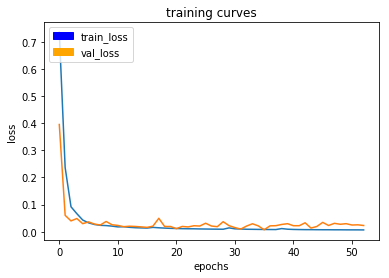

381/381 [==============================] - 748s - loss: 0.0065 - val_loss: 0.0228
Epoch 54/100
380/381 [============================>.] - ETA: 1s - loss: 0.0064

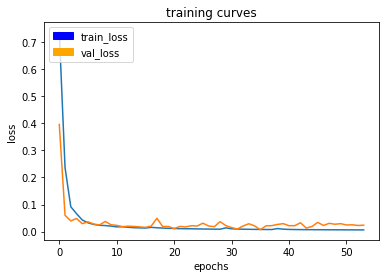

381/381 [==============================] - 748s - loss: 0.0064 - val_loss: 0.0239
Epoch 55/100
380/381 [============================>.] - ETA: 1s - loss: 0.0064

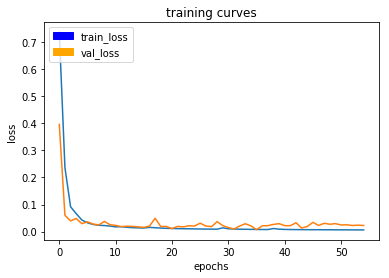

381/381 [==============================] - 748s - loss: 0.0064 - val_loss: 0.0227
Epoch 56/100
380/381 [============================>.] - ETA: 1s - loss: 0.0063

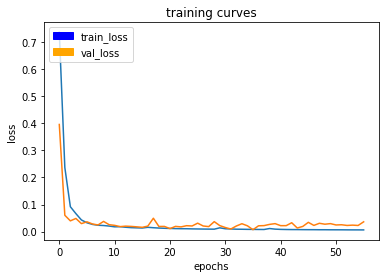

381/381 [==============================] - 748s - loss: 0.0063 - val_loss: 0.0362
Epoch 57/100
380/381 [============================>.] - ETA: 1s - loss: 0.0062

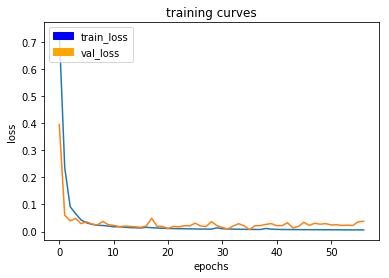

381/381 [==============================] - 748s - loss: 0.0062 - val_loss: 0.0380
Epoch 58/100
380/381 [============================>.] - ETA: 1s - loss: 0.0061

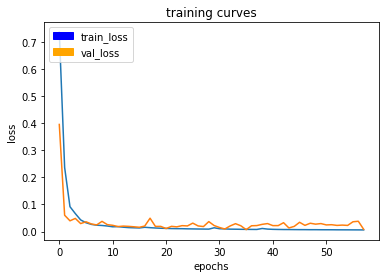

381/381 [==============================] - 748s - loss: 0.0061 - val_loss: 0.0083
Epoch 59/100
380/381 [============================>.] - ETA: 1s - loss: 0.0060

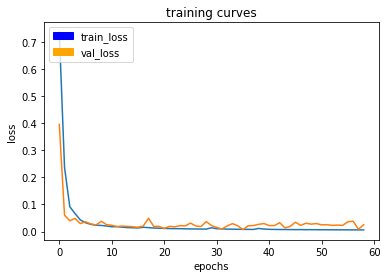

381/381 [==============================] - 748s - loss: 0.0060 - val_loss: 0.0250
Epoch 60/100
380/381 [============================>.] - ETA: 1s - loss: 0.0060

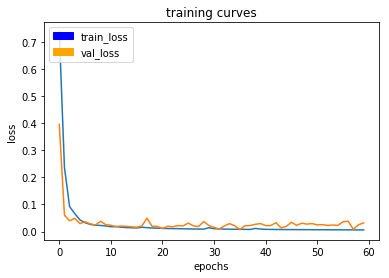

381/381 [==============================] - 749s - loss: 0.0060 - val_loss: 0.0319
Epoch 61/100
380/381 [============================>.] - ETA: 1s - loss: 0.0060

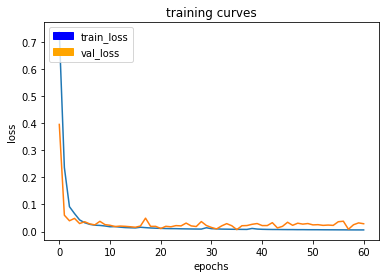

381/381 [==============================] - 748s - loss: 0.0060 - val_loss: 0.0288
Epoch 62/100
380/381 [============================>.] - ETA: 1s - loss: 0.0058

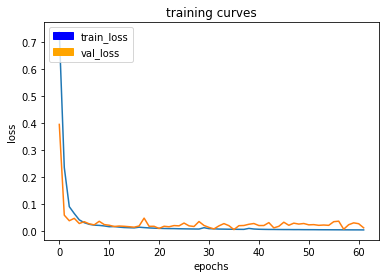

381/381 [==============================] - 748s - loss: 0.0058 - val_loss: 0.0135
Epoch 63/100
380/381 [============================>.] - ETA: 1s - loss: 0.0057

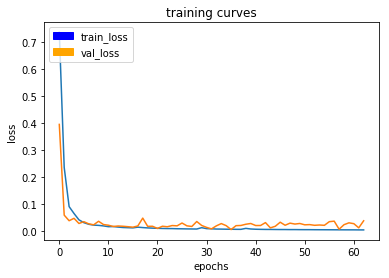

381/381 [==============================] - 748s - loss: 0.0057 - val_loss: 0.0394
Epoch 64/100
380/381 [============================>.] - ETA: 1s - loss: 0.0057

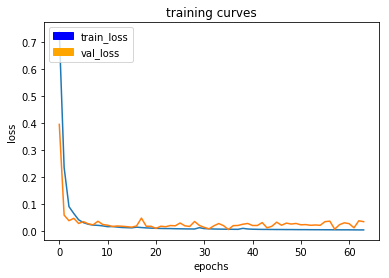

381/381 [==============================] - 747s - loss: 0.0057 - val_loss: 0.0361
Epoch 65/100
380/381 [============================>.] - ETA: 1s - loss: 0.0056

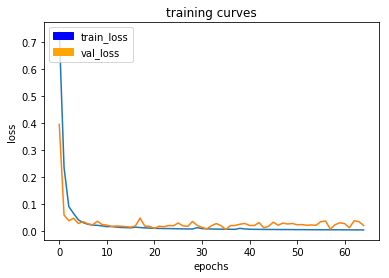

381/381 [==============================] - 746s - loss: 0.0056 - val_loss: 0.0220
Epoch 66/100
380/381 [============================>.] - ETA: 1s - loss: 0.0056

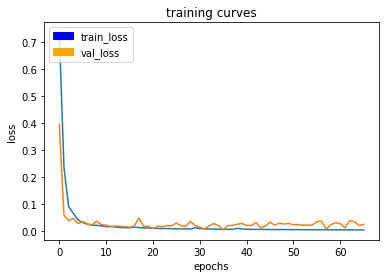

381/381 [==============================] - 747s - loss: 0.0056 - val_loss: 0.0257
Epoch 67/100
380/381 [============================>.] - ETA: 1s - loss: 0.0055

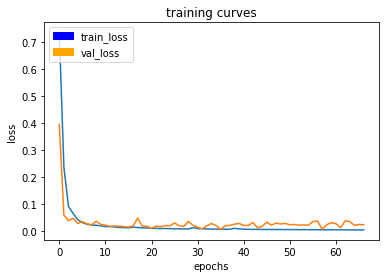

381/381 [==============================] - 746s - loss: 0.0055 - val_loss: 0.0245
Epoch 68/100
380/381 [============================>.] - ETA: 1s - loss: 0.0055

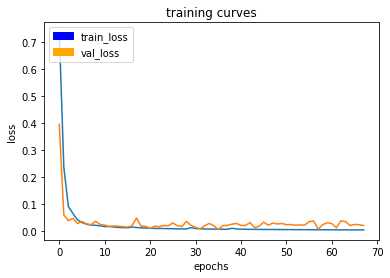

381/381 [==============================] - 746s - loss: 0.0055 - val_loss: 0.0217
Epoch 69/100
380/381 [============================>.] - ETA: 1s - loss: 0.0054

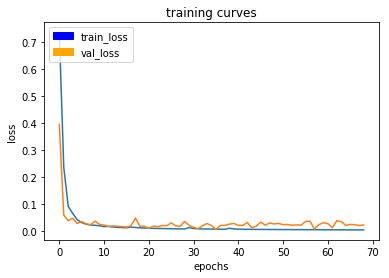

381/381 [==============================] - 748s - loss: 0.0054 - val_loss: 0.0236
Epoch 70/100
380/381 [============================>.] - ETA: 1s - loss: 0.0054

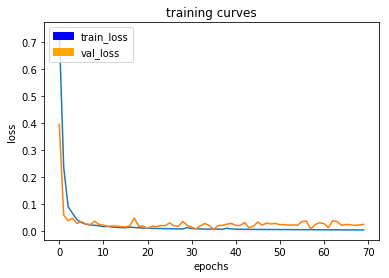

381/381 [==============================] - 748s - loss: 0.0054 - val_loss: 0.0259
Epoch 71/100
380/381 [============================>.] - ETA: 1s - loss: 0.0053

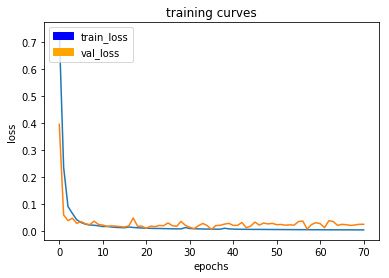

381/381 [==============================] - 749s - loss: 0.0053 - val_loss: 0.0261
Epoch 72/100
380/381 [============================>.] - ETA: 1s - loss: 0.0052

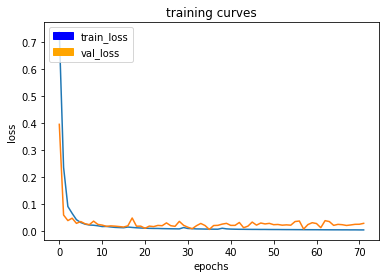

381/381 [==============================] - 747s - loss: 0.0052 - val_loss: 0.0295
Epoch 73/100
380/381 [============================>.] - ETA: 1s - loss: 0.0052

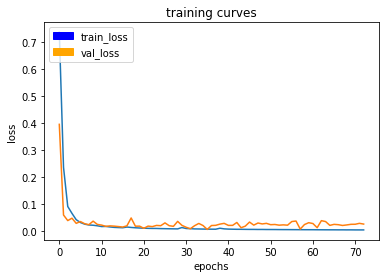

381/381 [==============================] - 749s - loss: 0.0052 - val_loss: 0.0268
Epoch 74/100
380/381 [============================>.] - ETA: 1s - loss: 0.0051

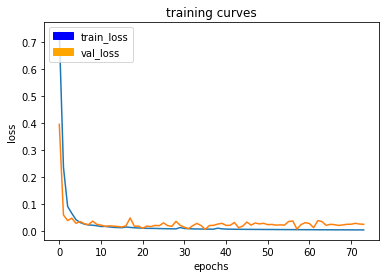

381/381 [==============================] - 747s - loss: 0.0051 - val_loss: 0.0260
Epoch 75/100
380/381 [============================>.] - ETA: 1s - loss: 0.0051

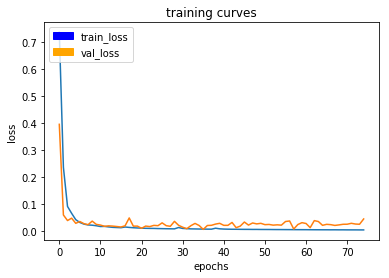

381/381 [==============================] - 747s - loss: 0.0051 - val_loss: 0.0455
Epoch 76/100
380/381 [============================>.] - ETA: 1s - loss: 0.0052

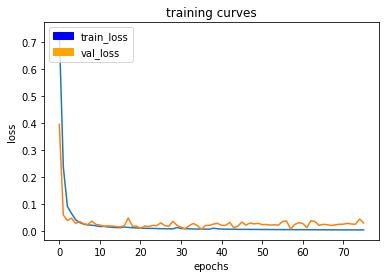

381/381 [==============================] - 746s - loss: 0.0052 - val_loss: 0.0307
Epoch 77/100
380/381 [============================>.] - ETA: 1s - loss: 0.0050

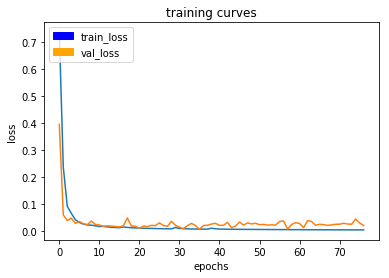

381/381 [==============================] - 747s - loss: 0.0050 - val_loss: 0.0214
Epoch 78/100
380/381 [============================>.] - ETA: 1s - loss: 0.0050

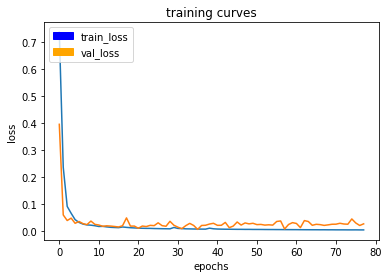

381/381 [==============================] - 747s - loss: 0.0050 - val_loss: 0.0274
Epoch 79/100
380/381 [============================>.] - ETA: 1s - loss: 0.0050

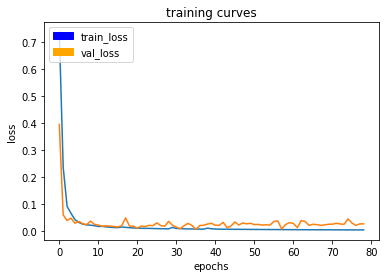

381/381 [==============================] - 747s - loss: 0.0050 - val_loss: 0.0272
Epoch 80/100
380/381 [============================>.] - ETA: 1s - loss: 0.0049

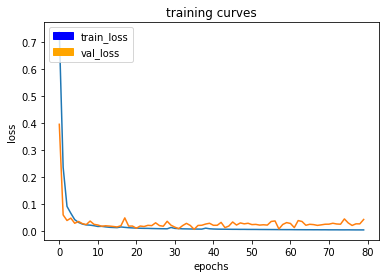

381/381 [==============================] - 748s - loss: 0.0049 - val_loss: 0.0435
Epoch 81/100
380/381 [============================>.] - ETA: 1s - loss: 0.0050

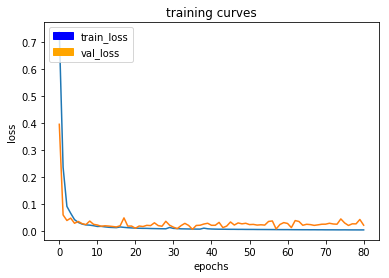

381/381 [==============================] - 746s - loss: 0.0050 - val_loss: 0.0223
Epoch 82/100
380/381 [============================>.] - ETA: 1s - loss: 0.0047

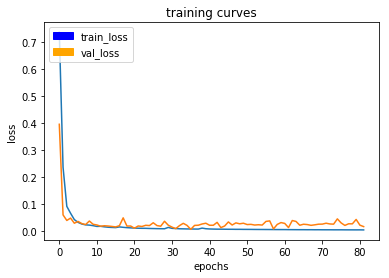

381/381 [==============================] - 746s - loss: 0.0047 - val_loss: 0.0170
Epoch 83/100
380/381 [============================>.] - ETA: 1s - loss: 0.0048

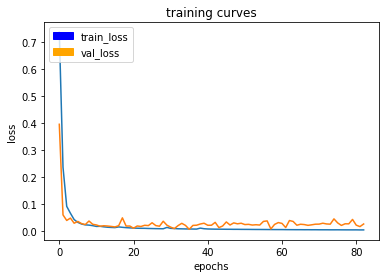

381/381 [==============================] - 747s - loss: 0.0048 - val_loss: 0.0267
Epoch 84/100
380/381 [============================>.] - ETA: 1s - loss: 0.0048

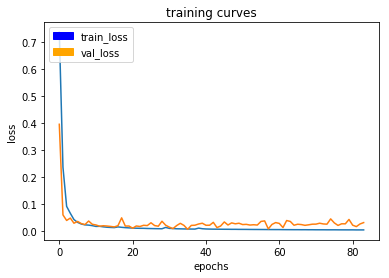

381/381 [==============================] - 746s - loss: 0.0048 - val_loss: 0.0318
Epoch 85/100
380/381 [============================>.] - ETA: 1s - loss: 0.0047

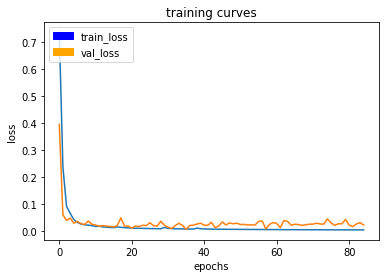

381/381 [==============================] - 747s - loss: 0.0047 - val_loss: 0.0225
Epoch 86/100
380/381 [============================>.] - ETA: 1s - loss: 0.0047

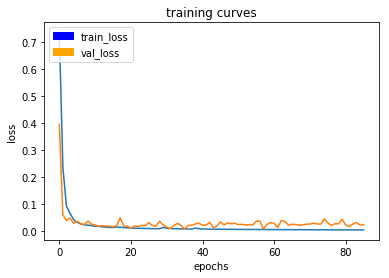

381/381 [==============================] - 748s - loss: 0.0047 - val_loss: 0.0236
Epoch 87/100
380/381 [============================>.] - ETA: 1s - loss: 0.0047

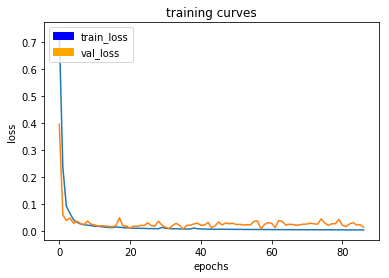

381/381 [==============================] - 746s - loss: 0.0046 - val_loss: 0.0151
Epoch 88/100
380/381 [============================>.] - ETA: 1s - loss: 0.0046

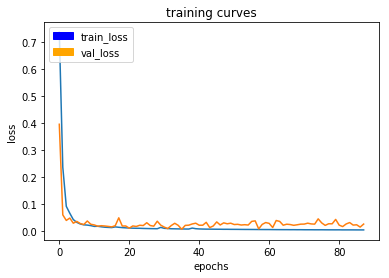

381/381 [==============================] - 747s - loss: 0.0046 - val_loss: 0.0262
Epoch 89/100
380/381 [============================>.] - ETA: 1s - loss: 0.0046

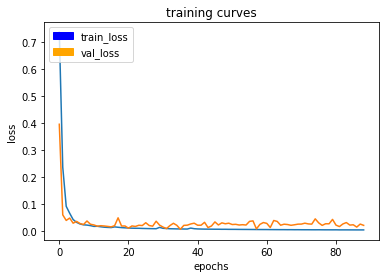

381/381 [==============================] - 746s - loss: 0.0046 - val_loss: 0.0215
Epoch 90/100
380/381 [============================>.] - ETA: 1s - loss: 0.0046

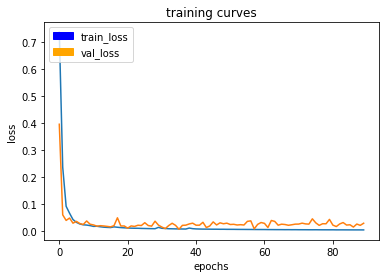

381/381 [==============================] - 747s - loss: 0.0046 - val_loss: 0.0292
Epoch 91/100
380/381 [============================>.] - ETA: 1s - loss: 0.0045

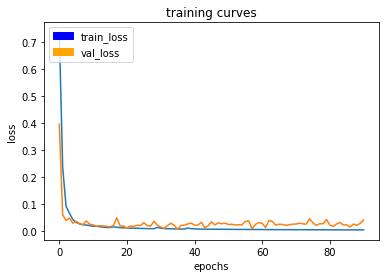

381/381 [==============================] - 746s - loss: 0.0045 - val_loss: 0.0409
Epoch 92/100
380/381 [============================>.] - ETA: 1s - loss: 0.0045

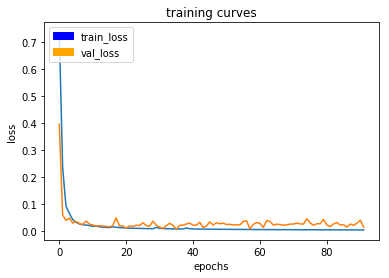

381/381 [==============================] - 749s - loss: 0.0045 - val_loss: 0.0140
Epoch 93/100
380/381 [============================>.] - ETA: 1s - loss: 0.0045

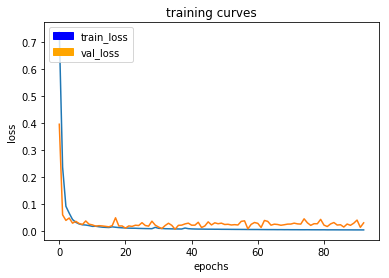

381/381 [==============================] - 748s - loss: 0.0045 - val_loss: 0.0306
Epoch 94/100
380/381 [============================>.] - ETA: 1s - loss: 0.0044

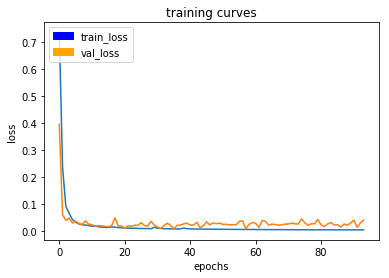

381/381 [==============================] - 747s - loss: 0.0044 - val_loss: 0.0409
Epoch 95/100
380/381 [============================>.] - ETA: 1s - loss: 0.0059

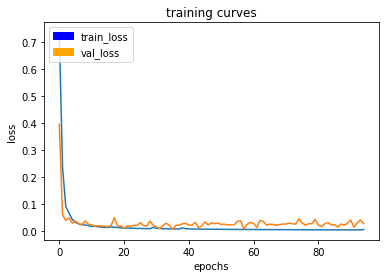

381/381 [==============================] - 747s - loss: 0.0059 - val_loss: 0.0274
Epoch 96/100
380/381 [============================>.] - ETA: 1s - loss: 0.0059

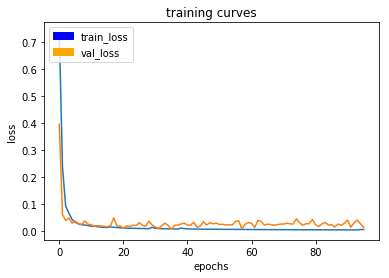

381/381 [==============================] - 747s - loss: 0.0059 - val_loss: 0.0132
Epoch 97/100
380/381 [============================>.] - ETA: 1s - loss: 0.0061

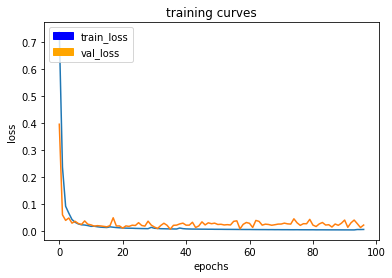

381/381 [==============================] - 748s - loss: 0.0061 - val_loss: 0.0224
Epoch 98/100
380/381 [============================>.] - ETA: 1s - loss: 0.0078

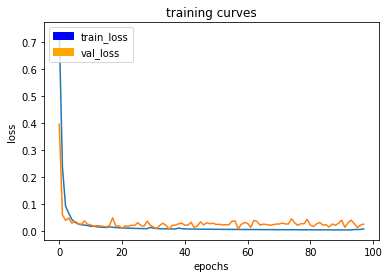

381/381 [==============================] - 746s - loss: 0.0078 - val_loss: 0.0258
Epoch 99/100
380/381 [============================>.] - ETA: 1s - loss: 0.0058

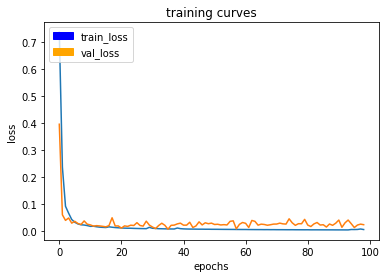

381/381 [==============================] - 749s - loss: 0.0058 - val_loss: 0.0237
Epoch 100/100
380/381 [============================>.] - ETA: 1s - loss: 0.0051

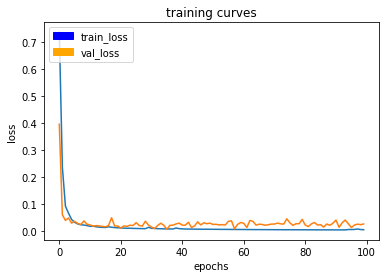

381/381 [==============================] - 746s - loss: 0.0051 - val_loss: 0.0264


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

#model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')
model.compile(optimizer=keras.optimizers.Nadam(lr=learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [11]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

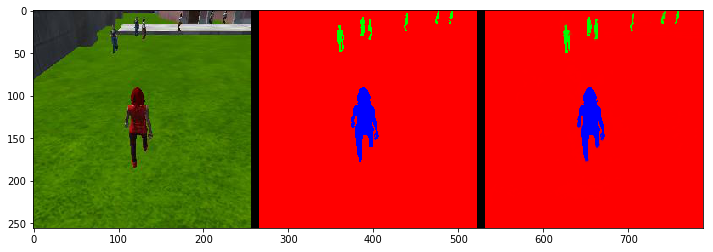

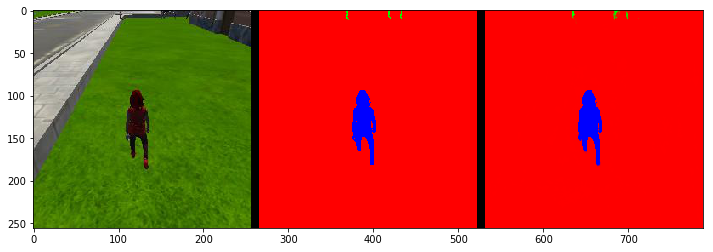

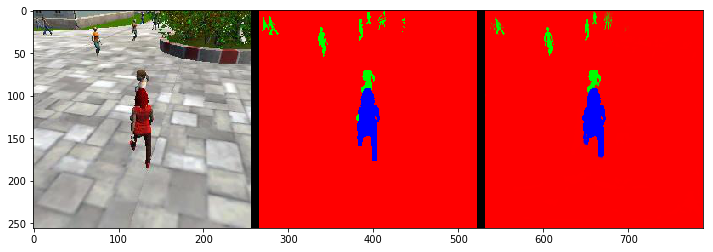

In [12]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

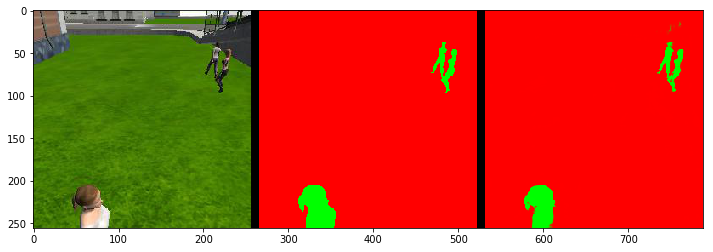

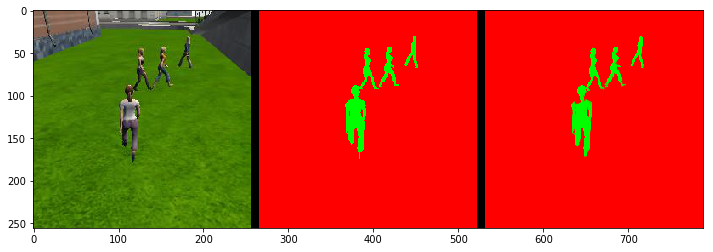

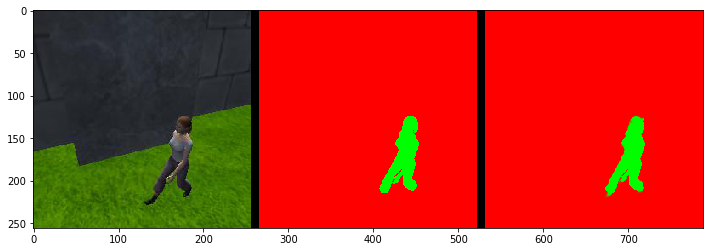

In [13]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

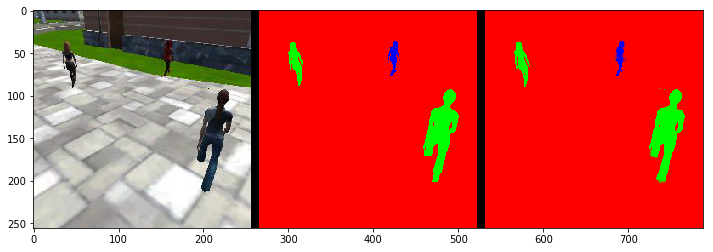

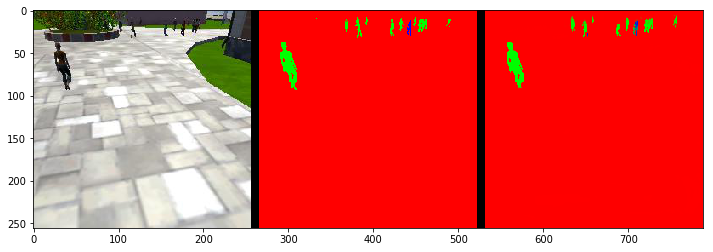

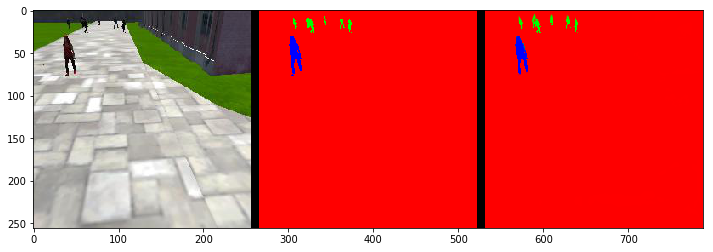

In [14]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [15]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9982427353389632
average intersection over union for other people is 0.5160735910630938
average intersection over union for the hero is 0.9659108755647347
number true positives: 539, number false positives: 0, number false negatives: 0


In [16]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9949634014289437
average intersection over union for other people is 0.9014836422345917
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 9, number false negatives: 0


In [17]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9985111016594956
average intersection over union for other people is 0.6360368342494613
average intersection over union for the hero is 0.4852559042477404
number true positives: 201, number false positives: 0, number false negatives: 111


In [18]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.8604651162790697


In [19]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.725583389906


In [20]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.624339195966
